In [30]:
import rasterio
import glob
from matplotlib import pyplot as plt
from rasterio.plot import show, show_hist
import numpy as np
from osgeo import gdal
importing -> list of tif files -> normalization (rio.open and 0-1 values and change crs) -> mosaic -> ndvi

In [11]:
file_pattern = r'D:\csulb\rrr_project\RRR_Imagery\05102021_MSP\script_t\*.tif'
imgs = glob.glob(file_pattern)
imgs.sort()

In [12]:
imgs

['D:\\csulb\\rrr_project\\RRR_Imagery\\05102021_MSP\\script_t\\2021_05_10_sw_rrr05102021msp_block_mosaic_1blue.tif',
 'D:\\csulb\\rrr_project\\RRR_Imagery\\05102021_MSP\\script_t\\2021_05_10_sw_rrr05102021msp_block_mosaic_2green.tif',
 'D:\\csulb\\rrr_project\\RRR_Imagery\\05102021_MSP\\script_t\\2021_05_10_sw_rrr05102021msp_block_mosaic_3red.tif',
 'D:\\csulb\\rrr_project\\RRR_Imagery\\05102021_MSP\\script_t\\2021_05_10_sw_rrr05102021msp_block_mosaic_4nir.tif']

In [15]:
normalized_imgs = []
def normalize(img_list):
    for img in img_list:
        arr = rasterio.open(img).read(1)
        arr_min, arr_max = arr.min(), arr.max()
        normalized_img = ((arr - arr_min)/(arr_max - arr_min))
        normalized_imgs.append(normalized_img)

In [16]:
normalize(imgs)

In [17]:
normalized_imgs[0].dtype

dtype('float64')

In [20]:
mosaic = np.stack(normalized_imgs, axis=0)
with rasterio.open(imgs[0]) as src:
    meta = src.meta.copy()
# Update the metadata for the mosaic
meta.update(count=mosaic.shape[0], dtype=str(mosaic.dtype))

In [22]:
with rasterio.open(r'D:\csulb\rrr_project\RRR_Imagery\05102021_MSP\script_t\mosaic_uav.tif', 'w', **meta) as dst:
    dst.write(mosaic)
    dst.close()

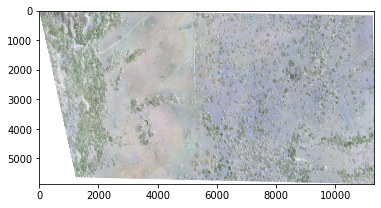

<Axes: >

In [27]:
uav_stack = rasterio.open(r'D:\csulb\rrr_project\RRR_Imagery\05102021_MSP\script_t\mosaic_uav.tif')
uav_stack_r = uav_stack.read()
show(uav_stack_r)

In [24]:
with rasterio.open(r'D:\csulb\rrr_project\RRR_Imagery\05102021_MSP\script_t\mosaic_uav.tif') as src:
    red = src.read(3)
    nir = src.read(4)
    
    ndvi = (nir - red) / (nir + red)
    
    with rasterio.open(r'D:\csulb\rrr_project\RRR_Imagery\05102021_MSP\script_t\ndvi_uav.tif', 'w', driver='Gtiff',
                                    width=src.width,
                                    height=src.height,
                                    count=1,
                                    crs=src.crs,
                                    transform=src.transform,
                                    dtype='float64') as dst:
        dst.write(ndvi, 1)
        dst.close()

<ipython-input-24-d7719946ac94>:5: RuntimeWarning: invalid value encountered in divide
  ndvi = (nir - red) / (nir + red)


In [28]:
uav_stack.meta

{'driver': 'GTiff',
 'dtype': 'float64',
 'nodata': None,
 'width': 11319,
 'height': 5858,
 'count': 4,
 'crs': CRS.from_epsg(32611),
 'transform': Affine(0.1, 0.0, 337819.90001000004,
        0.0, -0.1, 4003533.836)}

In [36]:
uav_32611 = gdal.Open(r'D:\csulb\rrr_project\RRR_Imagery\05102021_MSP\script_t\ndvi_uav.tif')
uav_3857 = r'D:\csulb\rrr_project\RRR_Imagery\05102021_MSP\script_t\ndvi_uav_3857.tif'
warp = gdal.Warp('uav_3857.tif', uav_32611, dstSRS='EPSG:3857')
